In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import rasterio
import tqdm
import pandas as pd
import rasterio
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as v2
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

from terratorch.models.pixel_wise_model import freeze_module
from huggingface_hub import hf_hub_download
from terratorch.models.backbones.prithvi_mae import PrithviViT

In [2]:
def set_seed(seed):
    torch.manual_seed(seed) # Set seed for Python's built-in random number generator
    np.random.seed(seed) # Set seed for numpy
    if torch.cuda.is_available(): # Set seed for CUDA if available
        torch.cuda.manual_seed_all(seed)
        # Set cuDNN's random number generator seed for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
class prithvi_terratorch(nn.Module):
  def __init__(self, prithvi_weight, model_instance, input_size):
    super(prithvi_terratorch, self).__init__()
    # load checkpoint for Prithvi_global
    self.weights_path = prithvi_weight
    self.checkpoint = torch.load(self.weights_path)
    self.input_size = input_size
    self.prithvi_model = model_instance   
    self.prithvi_model.load_state_dict(self.checkpoint, strict=False)

  def freeze_encoder(self):
    freeze_module(self.prithvi_model)

  def forward(self,x,temp,loc,mask):
    latent,_,ids_restore = self.prithvi_model.forward(x,temp,loc,mask)
    return latent

In [4]:
def load_raster(path, if_img=1, crop=None):
  with rasterio.open(path) as src:
    img = src.read(out_dtype=np.float32)
    # load  selected 4 bands for Sentinnel 2 (S2)
    if if_img==1:
      bands=[0,1,2,3]
      img = img[bands,:,:]
    # img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)# update our NO_DATA with -0.9999 -- chips are already scaled
    # print("img size",img.shape) 
    if crop:
      img = img[:, -crop[0]:, -crop[1]:]
  # print('return from load ras')
  return img

def preprocess_image(image, means, stds):        
    # normalize image
    means1 = means.reshape(-1,1,1)  # Mean across height and width, for each channel
    stds1 = stds.reshape(-1,1,1)    # Std deviation across height and width, for each channel
    normalized = ((image - means1) / stds1)
    normalized = torch.from_numpy(normalized).to(torch.float32)
    #normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    #print('return from norm')
    return normalized

In [5]:
class TestDataset(Dataset):
    def __init__(self, dir_sentinel, dir_landsat, dir_bioclim, metadata, cov_columns, subset, num_classes=None, transform_sentinel=None, transform_landsat=None,
                 mean_sentinel=np.array([0.0]), std_sentinel=np.array([1.0])):
        self.subset = subset
        self.transform_sentinel = transform_sentinel
        self.mean_sentinel = np.array(mean_sentinel)
        self.std_sentinel = np.array(std_sentinel)
        self.transform_landsat = transform_landsat
        self.dir_sentinel = dir_sentinel
        self.dir_landsat = dir_landsat
        self.dir_bioclim = dir_bioclim
        self.metadata = metadata
        self.cov_columns = cov_columns
        self.num_classes = num_classes
        if self.subset == "test":
            self.landsat_file_sep = "_"
        elif self.subset == "train":
            self.landsat_file_sep = "-"

    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        survey_id = self.metadata.surveyId[idx]
        cov = torch.tensor(self.metadata.loc[idx, self.cov_columns].values.astype(np.float32))
        lonlat = torch.tensor(self.metadata.loc[idx, ["lon","lat"]].values.astype(np.float32))
        path_landsat = os.path.join(self.dir_landsat, f"GLC25-PA-{self.subset}-landsat{self.landsat_file_sep}time{self.landsat_file_sep}series_{survey_id}_cube.pt")
        sample_landsat = torch.nan_to_num(torch.load(path_landsat, weights_only=True)[:,:,:landsat_year_len])
        if self.transform_landsat:
            sample_landsat = self.transform_landsat(sample_landsat)
        path_bioclim = os.path.join(self.dir_bioclim, f"GLC25-PA-{self.subset}-bioclimatic_monthly_{survey_id}_cube.pt")
        sample_bioclim = torch.nan_to_num(torch.load(path_bioclim, weights_only=True))
        #print(sample_bioclim.shape)
        tmp1 = torch.reshape(sample_bioclim, [4,-1])
        tmp2 = torch.reshape(torch.cat([tmp1[:,:1], tmp1[:,:bioclim_month_len]], axis=-1), [4,landsat_year_len,4,3])
        sample_bioclim_new = torch.permute(torch.mean(tmp2, -1), [0,2,1])[:2] 
        sample_bioclim_new = (sample_bioclim_new - np.array([0,2730], np.float32)[:,None,None]) / np.array([5000,300], np.float32)[:,None,None]
        #print(sample_bioclim_new.shape)
        sample_landsat = torch.cat([sample_landsat, sample_bioclim_new], 0)
        #print(sample_landsat.shape)
        dir1, dir2 = str(survey_id)[-2:], str(survey_id)[-4:-2]        
        path_sentinel = os.path.join(self.dir_sentinel, dir1, dir2, f"{survey_id}.tiff")
        image_sentinel = preprocess_image(load_raster(path_sentinel) / 1e4, self.mean_sentinel, self.std_sentinel)
        sample_sentinel = torch.nan_to_num(image_sentinel)
        if self.transform_sentinel:
            sample_sentinel = self.transform_sentinel(sample_sentinel)
        return sample_sentinel, sample_landsat, cov, lonlat, survey_id

class TrainDataset(TestDataset):
  def __init__(self, dir_sentinel, dir_landsat, dir_bioclim, metadata, cov_columns, label_dict, subset, num_classes, transform_sentinel=None, transform_landsat=None,
              mean_sentinel=np.array([0.0]), std_sentinel=np.array([1.0])):
    super(TrainDataset, self).__init__(dir_sentinel, dir_landsat, dir_bioclim, metadata, cov_columns, subset, num_classes, transform_sentinel, transform_landsat,
              mean_sentinel, std_sentinel)
    self.label_dict = label_dict

  def __getitem__(self, idx):
    sample_sentinel, sample_landsat, cov, lonlat, survey_id = super(TrainDataset, self).__getitem__(idx)
    species_ids = self.label_dict.get(survey_id, [])  # Get list of species IDs for the survey ID
    label = torch.zeros(self.num_classes).scatter(0, torch.tensor(species_ids), torch.ones(len(species_ids)))
    return sample_sentinel, sample_landsat, cov, lonlat, label, survey_id

In [6]:
batch_size = 32
num_workers = 8
num_classes = 11255
landsat_year_len = 18
bioclim_month_len = landsat_year_len*12-1
mean_sentinel = [0.1]
std_sentinel = [0.13]
validation_prop = 0.1
transform_landsat = v2.Compose([
    # v2.RandomRotation(180)
])

transform_sentinel = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(180)
])

# Load Training metadata
set_seed(42)
path_data = "/home/gt/DATA/geolifeclef-2025"
train_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-train")
train_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-train")
train_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-train")
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_label_series = train_metadata.groupby('surveyId')['speciesId'].apply(list)
train_metadata = train_metadata.drop_duplicates(subset="surveyId").reset_index(drop=True).drop('speciesId', axis=1)
train_metadata.replace([np.inf, -np.inf], np.nan, inplace=True)
train_metadata['areaInM2'].fillna((train_metadata['areaInM2'].mean()), inplace=True)
train_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-train-elevation.csv"))
train_elevation.replace([np.inf, -np.inf], np.nan, inplace=True)
train_elevation['Elevation'].fillna((train_elevation['Elevation'].mean()), inplace=True)
train_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-train-soilgrids.csv"))
train_soil.replace([np.inf, -np.inf], np.nan, inplace=True)
for column in train_soil.columns: train_soil[column].fillna((train_soil[column].mean()), inplace=True)
cov_columns = ["areaInM2", "Elevation"] + list(train_soil.columns[1:])
print((train_metadata.surveyId==train_elevation.surveyId).all())
print("All rows match: ", (train_metadata.surveyId==train_elevation.surveyId).all() and (train_metadata.surveyId==train_soil.surveyId).all())
train_combined = pd.concat([train_metadata, train_elevation.Elevation, train_soil.drop("surveyId", axis=1)], axis=1)
cov_norm_coef = train_combined.loc[:,cov_columns].agg(['mean', 'std'])
train_combined.loc[:,cov_columns] = (train_combined.loc[:,cov_columns] - cov_norm_coef.loc["mean"]) / cov_norm_coef.loc["std"]

train_survey_groups = list(train_combined.groupby("surveyId"))
val_ind = np.sort(train_combined.surveyId.sample(frac=validation_prop).values)
train_data, val_data = [x.reset_index(drop=True) for _, x in train_combined.groupby(train_combined.surveyId.isin(val_ind))]
train_label_dict = train_label_series[train_data.surveyId].to_dict()
val_label_dict = train_label_series[val_data.surveyId].to_dict()
train_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_path_bioclim, train_data, cov_columns, train_label_dict, 
                             subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel,
                             mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_path_bioclim, val_data, cov_columns, val_label_dict,
                           subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel,
                           mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

True
All rows match:  True


In [7]:
train_combined.loc[:,cov_columns].agg(['mean', 'std'])

,areaInM2,Elevation,Soilgrid-bdod,Soilgrid-cec,Soilgrid-cfvo,Soilgrid-clay,Soilgrid-nitrogen,Soilgrid-phh2o,Soilgrid-sand,Soilgrid-silt,Soilgrid-soc
mean,-5.749051e-18,-9.022816e-18,1.503177e-15,4.618404e-16,3.138023e-16,-1.443650e-16,-4.611218e-17,1.021415e-15,2.529582e-16,3.008670e-16,9.258367e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


train size:  80088  | validation size:  8899
torch.Size([4, 64, 64])
torch.Size([11])


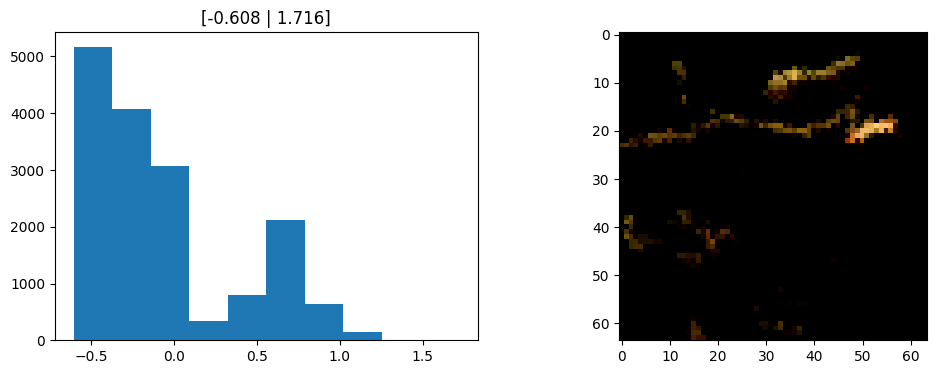

In [8]:
print("train size: ", len(train_dataset), " | validation size: ", len(val_dataset))
print(train_dataset[0][0].shape)
print(val_dataset[0][2].shape)
plt.figure(figsize=[12,4])
plt.subplot(1, 2, 1)
plt.hist(train_dataset[0][0].flatten())
plt.title("[%.3f | %.3f]" % (np.min(train_dataset[0][0].numpy()), np.max(train_dataset[0][0].numpy())))
plt.subplot(1, 2, 2)
plt.imshow(torch.permute(train_dataset[0][0][:3], [1,2,0]))
plt.show()

In [9]:
# Load Test metadata
test_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-test")
test_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-test")
test_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-test")
test_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_test.csv"))
test_metadata.replace([np.inf, -np.inf], np.nan, inplace=True)
test_metadata['areaInM2'].fillna((test_metadata['areaInM2'].mean()), inplace=True)
test_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-test-elevation.csv"))
test_elevation = test_elevation.loc[test_elevation.surveyId.isin(test_metadata.surveyId)].reset_index(drop=True)
test_elevation.replace([np.inf, -np.inf], np.nan, inplace=True)
test_elevation['Elevation'].fillna((test_elevation['Elevation'].mean()), inplace=True)
test_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-test-soilgrids.csv"))
test_soil = test_soil.loc[test_soil.surveyId.isin(test_metadata.surveyId)].reset_index(drop=True)
test_soil.replace([np.inf, -np.inf], np.nan, inplace=True)
for column in test_soil.columns: test_soil[column].fillna((test_soil[column].mean()), inplace=True)
print("All rows match: ", (test_metadata.surveyId==test_elevation.surveyId).all() and (test_metadata.surveyId==test_soil.surveyId).all())
test_combined = pd.concat([test_metadata, test_elevation.Elevation, test_soil.drop("surveyId", axis=1)], axis=1)
test_combined.loc[:,cov_columns] = (test_combined.loc[:,cov_columns] - cov_norm_coef.loc["mean"]) / cov_norm_coef.loc["std"]
test_dataset = TestDataset(test_path_sentinel, test_path_landsat, test_path_bioclim, test_combined, cov_columns, subset="test", transform_sentinel=None,
                          mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(test_dataset[0][0].shape)

All rows match:  True
torch.Size([4, 64, 64])


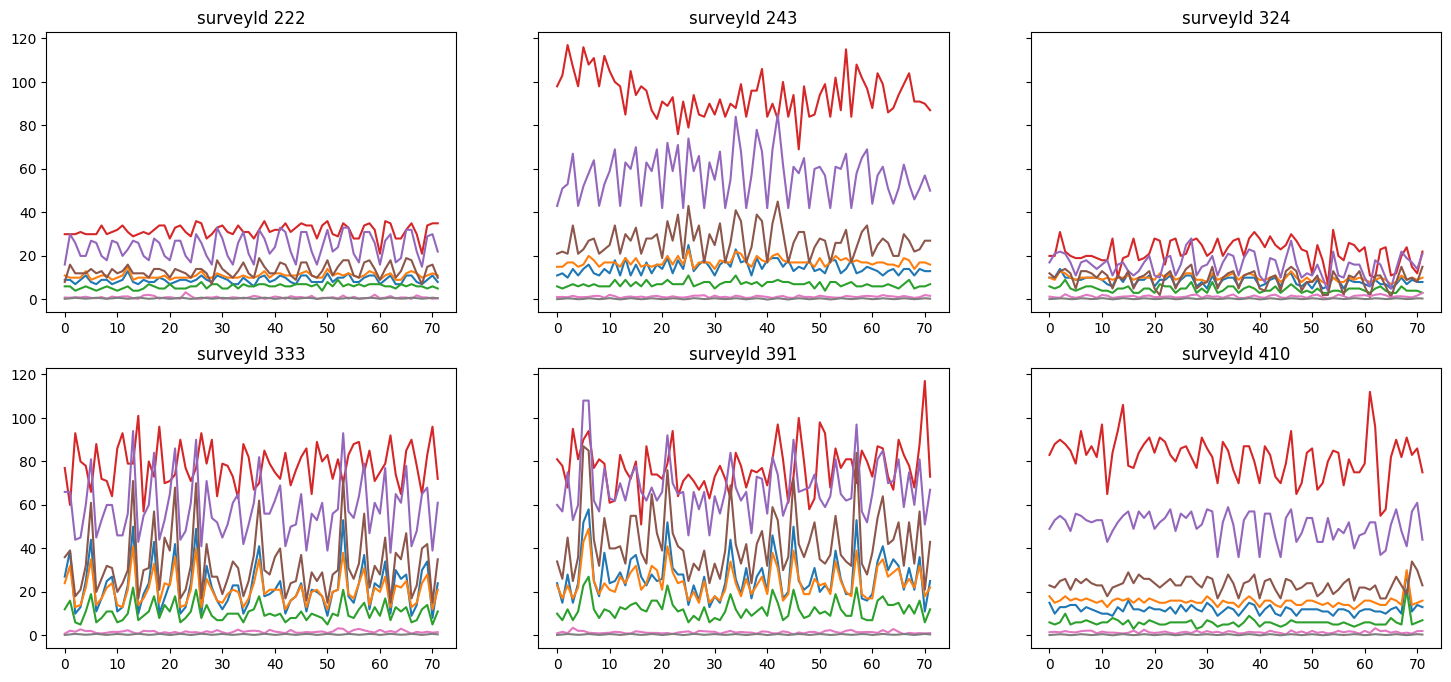

In [10]:
fig, axes = plt.subplots(2, 3, squeeze=False, sharey="all", figsize=[18,8])
id_im = 0*6
for idr, axr in enumerate(axes):
    for idc, ax in enumerate(axr):
        for ch in range(train_dataset[id_im][1].shape[0]):
            ax.plot(torch.transpose(train_dataset[id_im][1][ch], 1,0).numpy().reshape(-1))
        id_im += 1
        ax.set_title("surveyId %d"%train_dataset[id_im][-1])
fig.show()

In [11]:
patch_size = [1,16,16]
n_frame = 1
n_channel = 4
embed_dim = 1024
decoder_depth = 8
num_heads = 16
mlp_ratio = 4
head_dropout = 0.0
      
path_prithvi = "/home/gt/gdrive/codes_misc/prithvi/carbon_flux"
wt_file = os.path.join(path_prithvi, "Prithvi_EO_V2_300M_TL.pt")
if not os.path.isfile(wt_file):
  hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL", filename="Prithvi_EO_V2_300M_TL.pt", local_dir=path_prithvi)

prithvi_instance = PrithviViT(
        patch_size=patch_size,
        num_frames=n_frame,
        in_chans=n_channel,
        embed_dim=embed_dim,
        decoder_depth=decoder_depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        head_dropout=head_dropout,
        backbone_input_size=[1,64,64],
        encoder_only=False,
        padding=True,
)
prithvi_model = prithvi_terratorch(wt_file, prithvi_instance, [1,64,64])
prithvi_model.freeze_encoder()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("DEVICE = CUDA")
prithvi_model.to(device);

DEVICE = CUDA


In [12]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet18, self).__init__()
        self.norm_input = nn.LayerNorm([8,4,18])
        self.resnet18 = models.resnet18(weights=None)
        # We have to modify the first convolutional layer to accept 4 channels instead of 3
        self.resnet18.conv1 = nn.Conv2d(8, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet18.maxpool = nn.Identity()
        self.ln = nn.LayerNorm(1000)
        #self.fc = nn.Linear(1000, 128)

    def forward(self, x):
        #x = self.norm_input(x)
        x = self.resnet18(x)
        #x = self.ln(x)
        #x = self.fc(x)
        return x

class SimpleDecoder(nn.Module):
    def __init__(self, input_dim=[17,1024], hidden_dim=256, output_dim=128):
        super(SimpleDecoder, self).__init__()
        self.fc1 = nn.Linear(input_dim[1], hidden_dim) # 1024 to 256; shape 17x1024 to 10x256
        self.hidden_dim_flattened=input_dim[0] * hidden_dim #17 is feature dim+ class token in MAE; 17x256 to 4352
        self.fc2 = nn.Linear(self.hidden_dim_flattened, output_dim) # 4352 to 128
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x)) #shape 17x1024 to 17x256 ORG
        x = torch.reshape(x,(x.shape[0], x.shape[1]*x.shape[2])) #17x256 to 4352 
        x = self.fc2(x) # 4352 to 128 Output shape 
        return x

class ModifiedPrithviResNet18(nn.Module):
    def __init__(self, num_classes, prithvi_model):
        super(ModifiedPrithviResNet18, self).__init__()
        self.prithvi_model = prithvi_model
        self.decoder = SimpleDecoder(input_dim=[17,1024], hidden_dim=256, output_dim=128)
        self.landsat_part = ModifiedResNet18(num_classes)
        self.drop_tail = nn.Dropout(0.5)
        self.fc_tail = nn.Linear(1000 + 128 + 11, 1000 + 128)
        self.relu_tail = nn.ReLU()
        self.drop_last = nn.Dropout(0.5)
        self.fc_final = nn.Linear(1000 + 128, num_classes)
        #self.fc_final = nn.Linear(1000, num_classes)

    def forward(self, sentinel, landsat, cov, lonlat=None):
        x = self.prithvi_model(sentinel, None, lonlat, torch.tensor(0, device=device))
        x0 = self.decoder(x)
        x1 = self.landsat_part(landsat)
        x = torch.concat([x0, x1, cov], -1)
        x = self.drop_tail(x)
        x = self.fc_tail(x)
        x = self.relu_tail(x)
        x = self.drop_last(x)
        x = self.fc_final(x)
        #x = self.fc_final(x1)
        return x

In [13]:
# Check if cuda is available
set_seed(69)
model = ModifiedPrithviResNet18(num_classes, prithvi_model).to(device)

In [14]:
#resNet18 = ModifiedResNet18(num_classes).to(device)
#summary(resNet18, (8, 4, 18))

#summary(model.landsat_part, [(4, 1, 64, 64), (6, 4, 21)])
#list(model.fc_final.named_parameters())
#[name for name, p in model.named_parameters()]

In [15]:
n = 10
sentinel_batch = torch.stack([train_dataset[i][0] for i in range(n)])[:,:,None,:,:]
landsat_batch = torch.stack([train_dataset[i][1] for i in range(n)])
cov_batch = torch.stack([train_dataset[i][2] for i in range(n)])
lonlat_batch = torch.stack([train_dataset[i][3] for i in range(n)])
prithvi_res = prithvi_model.forward(sentinel_batch.to(device), None, lonlat_batch.to(device), torch.tensor(0, device=device))
print(prithvi_res.to(device).shape)
model_res = model.forward(sentinel_batch.to(device), landsat_batch.to(device), cov_batch.to(device), lonlat_batch.to(device))
print(model_res.shape)

torch.Size([10, 17, 1024])
torch.Size([10, 11255])


In [16]:
# Hyperparameters
learning_rate = 0.0002
weight_decay_tail = 1e-4
num_epochs = 13
positive_weigh_factor = 1.0

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

tail_weight_names = ['fc_final.weight', 'fc_tail.weight']
print([name for name, p in model.named_parameters() if any([par_tail_name in name for par_tail_name in tail_weight_names])])
last_layer_weights = [p for name, p in model.named_parameters() if any([par_tail_name in name for par_tail_name in tail_weight_names])]
others = [p for name, p in model.named_parameters() if not any([par_tail_name in name for par_tail_name in tail_weight_names])]
optim_dict = [{"params": others}, {"params": last_layer_weights, "weight_decay": weight_decay_tail}]
optimizer = torch.optim.AdamW(optim_dict, lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25, verbose=True)

['fc_tail.weight', 'fc_final.weight']


In [53]:
def f1_score(outputs, targets=None, M=400, mult=1, offset=0):
    prob_ord = torch.argsort(outputs, dim=-1, descending=True)
    log_prob = torch.gather(outputs, -1, prob_ord)
    sample = torch.bernoulli(torch.sigmoid(log_prob).repeat(M, 1, 1))
    cum_sum = torch.cat([torch.zeros([M,outputs.shape[0],1],device=device), torch.cumsum(sample, -1)], -1)
    rev_cum_sum = torch.cat([torch.flip(torch.cumsum(torch.flip(sample, [-1]), -1), [-1]), torch.zeros([M,outputs.shape[0],1],device=device)], -1)
    f1_expected = torch.mean(cum_sum / (cum_sum + 0.5*(torch.arange(num_classes+1,device=device)-cum_sum) + 0.5*rev_cum_sum), 0)
    pred_num = torch.argmax(f1_expected, -1)
    pred_num = torch.maximum(torch.minimum(torch.round(mult*pred_num+offset), torch.Tensor([outputs.shape[-1]]).to(device)), torch.zeros([1],device=device)).int()
    if targets is None:
        pred_list = [prob_ord[i,:pred_num[i]] for i in range(outputs.shape[0])]
        return pred_list
    else:
        pred_list = [torch.cat([torch.ones([pred_num[i]],device=device), torch.zeros([outputs.shape[-1]-pred_num[i]],device=device)]) for i in range(outputs.shape[0])]
        targets_ordered = torch.gather(targets, -1, prob_ord)
        pred_ordered = torch.stack(pred_list)
        f1 = torch.sum(torch.logical_and(targets_ordered, pred_ordered), -1) / torch.sum(torch.logical_or(targets_ordered, pred_ordered), -1)
        return f1

In [18]:
print(f"Training for {num_epochs} epochs started.")
model.eval()
loss_array = np.zeros(len(val_loader))
f1_25_list, f1_opt_list = [None]*len(val_loader), [None]*len(val_loader)
for batch_idx, (data_sentinel, data_landsat, data_cov, data_lonlat, targets, _) in tqdm.tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
    data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
    data_landsat = data_landsat.to(device)
    data_cov = data_cov.to(device)
    data_lonlat = data_lonlat.to(device)
    targets = targets.to(device)
    outputs = model(data_sentinel, data_landsat, data_cov, data_lonlat)
    pos_weight = targets * positive_weigh_factor
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    loss = criterion(outputs, targets)
    loss_array[batch_idx] = loss.item()
    f1_25_list[batch_idx] = f1_score(outputs, targets, M=1, mult=0, offset=25)
    f1_opt_list[batch_idx] = f1_score(outputs, targets, M=101, mult=1, offset=0)
mean_val_loss = np.mean(loss_array)
mean_f1_25, mean_f1_opt = torch.mean(torch.cat(f1_25_list)), torch.mean(torch.cat(f1_opt_list))
print(f"Epoch {0}/{num_epochs}, train loss: NA; validation loss: {mean_val_loss:.6f}, F1-25: {mean_f1_25:.4f}, F1-opt: {mean_f1_opt:.4f}")

for epoch in range(num_epochs):
    model.train()
    loss_array = np.zeros(len(train_loader))
    for batch_idx, (data_sentinel, data_landsat, data_cov, data_lonlat, targets, _) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
        data_landsat = data_landsat.to(device)
        data_cov = data_cov.to(device)
        data_lonlat = data_lonlat.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(data_sentinel, data_landsat, data_cov, data_lonlat)
        pos_weight = targets * positive_weigh_factor
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(outputs, targets)
        loss_array[batch_idx] = loss.item()
        loss.backward()
        optimizer.step()
        # if batch_idx % 175 == 0:
        #     print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")
    mean_train_loss = np.mean(loss_array)
    
    model.eval()
    loss_array = np.zeros(len(val_loader))
    f1_25_list, f1_opt_list = [None]*len(val_loader), [None]*len(val_loader)
    for batch_idx, (data_sentinel, data_landsat, data_cov, data_lonlat, targets, _) in tqdm.tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
        data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
        data_landsat = data_landsat.to(device)
        data_cov = data_cov.to(device)
        data_lonlat = data_lonlat.to(device)
        targets = targets.to(device)
        outputs = model(data_sentinel, data_landsat, data_cov, data_lonlat)
        pos_weight = targets * positive_weigh_factor
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(outputs, targets)
        loss_array[batch_idx] = loss.item()
        f1_25_list[batch_idx] = f1_score(outputs, targets, M=1, mult=0, offset=25)
        f1_opt_list[batch_idx] = f1_score(outputs, targets, M=101, mult=1, offset=0)
    mean_val_loss = np.mean(loss_array)
    mean_f1_25, mean_f1_opt = torch.mean(torch.cat(f1_25_list)), torch.mean(torch.cat(f1_opt_list))
    print(f"Epoch {epoch+1}/{num_epochs}, train loss: {mean_train_loss:.6f}; validation loss: {mean_val_loss:.6f}, F1-25: {mean_f1_25:.4f}, F1-opt: {mean_f1_opt:.4f}")
    scheduler.step()
    # print("Scheduler:",scheduler.state_dict())


Training for 13 epochs started.


Epoch 0/13, train loss: NA, validation loss: 0.748229, f1-25: 0.0010, f1-optim: 0.0015


Epoch 1/13, train loss: 0.008202, validation loss: 0.004864, f1-25: 0.1994, f1-optim: 0.2093


Epoch 2/13, train loss: 0.004924, validation loss: 0.004553, f1-25: 0.2173, f1-optim: 0.2304


Epoch 3/13, train loss: 0.004638, validation loss: 0.004404, f1-25: 0.2286, f1-optim: 0.2444


Epoch 4/13, train loss: 0.004463, validation loss: 0.004326, f1-25: 0.2316, f1-optim: 0.2498


Epoch 5/13, train loss: 0.004337, validation loss: 0.004352, f1-25: 0.2302, f1-optim: 0.2471


Epoch 6/13, train loss: 0.004230, validation loss: 0.004186, f1-25: 0.2438, f1-optim: 0.2629


Epoch 7/13, train loss: 0.004132, validation loss: 0.004175, f1-25: 0.2439, f1-optim: 0.2633


Epoch 8/13, train loss: 0.004047, validation loss: 0.004134, f1-25: 0.2483, f1-optim: 0.2689


Epoch 9/13, train loss: 0.003965, validation loss: 0.004124, f1-25: 0.2487, f1-optim: 0.2708


Epoch 10/13, train loss: 0.003883, validation loss: 0.004110, f1-25: 0.2500, f1-optim: 0.2725


Epoch 11/13, train loss: 0.003805, validation loss: 0.004106, f1-25: 0.2499, f1-optim: 0.2720


Epoch 12/13, train loss: 0.003727, validation loss: 0.004106, f1-25: 0.2518, f1-optim: 0.2747


Epoch 13/13, train loss: 0.003654, validation loss: 0.004123, f1-25: 0.2527, f1-optim: 0.2763


In [19]:
# Save the trained model
model.eval()
torch.save(model.state_dict(), "prithvi-frozen-resnet18-tail2.pth")

In [56]:
most_train_countries = (train_metadata.country.value_counts().cumsum() / test_metadata.shape[0]).index[:10].values
model.eval()
with torch.no_grad():
    all_predictions = []
    surveys = []
    top_indices = []
    for data_sentinel, data_landsat, data_cov, data_lonlat, surveyId in tqdm.tqdm(test_loader, total=len(test_loader)):
        data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
        data_landsat = data_landsat.to(device)
        data_cov = data_cov.to(device)
        data_lonlat = data_lonlat.to(device)
        outputs = model(data_sentinel, data_landsat, data_cov, data_lonlat)
        top_batch_list = f1_score(outputs, None)
        top_batch_list = [np.sort(pred.cpu().numpy()) for pred in top_batch_list]
        #predictions = torch.sigmoid(outputs.cpu().numpy())
        ## Sellect top-25 values as predictions
        #top_batch = np.sort(np.argsort(-predictions, axis=1)[:, :25])
        #top_batch_list = top_batch.tolist()
        
        surveyId = surveyId.numpy()
        #tmp_metadata = test_metadata.loc[test_metadata.surveyId.isin(surveyId)]
        #tmp_metadata.set_index("surveyId", inplace=True)
        #tmp_metadata = tmp_metadata.loc[surveyId]
        #tmp_metadata.reset_index(drop=True, inplace=True)
        #tmp_metadata = tmp_metadata.loc[~tmp_metadata.country.isin(most_train_countries)]
        #for i in tmp_metadata.index:
        #    top_batch_list[i] = np.sort(train_metadata.value_counts("speciesId").index[:1000].values.astype(int))

        top_indices += top_batch_list
        surveys.extend(surveyId)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:32<00:00, 14.06it/s]


In [55]:
top_batch_list[0]

array([   53,   843,   963,  2025,  4483,  5189,  6962,  7942,  7957,
        7999,  8151,  8807, 10317, 10600])

In [57]:
data_concatenated = [' '.join(map(str, row)) for row in top_indices]

pd.DataFrame(
    {'surveyId': surveys,
     'predictions': data_concatenated,
    }).to_csv("submission_prithvi-frozen_bioresnet18_elev-soil_drop05_regl2e2_e13_optlist.csv", index = False)

In [23]:
#plt.plot(np.log(np.sort(predictions[0,:]))[-100:])

In [48]:
model.eval()
loss_array = np.zeros(len(val_loader))
f1_25_list, f1_opt_list = [None]*len(val_loader), [None]*len(val_loader)
for batch_idx, (data_sentinel, data_landsat, data_cov, data_lonlat, targets, _) in tqdm.tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
    data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
    data_landsat = data_landsat.to(device)
    data_cov = data_cov.to(device)
    data_lonlat = data_lonlat.to(device)
    targets = targets.to(device)
    outputs = model(data_sentinel, data_landsat, data_cov, data_lonlat)
    pos_weight = targets * positive_weigh_factor
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    loss = criterion(outputs, targets)
    loss_array[batch_idx] = loss.item()
    f1_25_list[batch_idx] = f1_score(outputs, targets, M=1, mult=0, offset=25)
    f1_opt_list[batch_idx] = f1_score(outputs, targets, M=101, mult=1, offset=0)
mean_val_loss = np.mean(loss_array)
mean_f1_25, mean_f1_opt = torch.mean(torch.cat(f1_25_list)), torch.mean(torch.cat(f1_opt_list))
print(f"Epoch {0}/{num_epochs}, train loss: NA; validation loss: {mean_val_loss:.6f}, F1-25: {mean_f1_25:.4f}, F1-opt: {mean_f1_opt:.4f}")

Epoch 0/13, train loss: NA; validation loss: 0.004122, F1-25: 0.2526, F1-opt: 0.2765
